https://machine-learning.club

In [238]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns



In [282]:
def create_dummies(data, column_name: str, prefix_name: str):
    dummie = pd.get_dummies(data[column_name], prefix=prefix_name) # Create columns for all the possibilities in attribute
    dummie = dummie.astype(int) # Convert boolean values into integers
    data.drop(column_name, axis=1, inplace=True) # Drop the attribute
    return dummie

In [285]:
def map_attribute(data: pd.DataFrame, to_map_attribute: str, new_attribute_name: str, map_func: dict) -> pd.DataFrame:
    data[new_attribute_name] = data[to_map_attribute].map(map_func)
    data = data.drop(to_map_attribute, axis=1)
    return data

In [240]:
def get_importances(clf):
	# Dictionary: Feature → Importance in %
    importances = {
        feature: round(importance * 100, 2)
        for feature, importance in zip(clf.feature_names_in_, clf.feature_importances_)
    }
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    return sorted_importances
	#formatted = [f"'{feature}' impact: {importance:.2f}%" for feature, importance in sorted_importances]
	#return formatted


In [241]:
def get_grid(model_regressor, x_train, y_train) -> GridSearchCV:
    # search for the perfect grid to get the max depth
	param_grid = {
    'max_depth':  list(range(2, 21)),
    'criterion': ['gini', 'entropy']
	}	
	find_grid = GridSearchCV(
		estimator=model_regressor,
  		scoring='f1',
		param_grid=param_grid,
		cv=5, # cross-validation with 5 folds
	)
	find_grid.fit(x_train, y_train)
	return find_grid

In [242]:
def handle_nan(x_train, y_train) -> tuple:
	# Remove rows with NaN values
    x_train_new = x_train.dropna()
    
    # Adapt `y_train` to the remaining lines
    y_train_new = y_train[x_train_new.index]

    return (x_train_new, y_train_new)

In [243]:
def synthetic_oversampling (x_train, y_train) -> tuple:
	# add new data
	smote = SMOTE(sampling_strategy='minority')
	x_train_new, y_train_new = smote.fit_resample(x_train, y_train)

	return (x_train_new, y_train_new)

In [244]:
def smote_enn_sampling(x_train, y_train) -> tuple:
    # Over-Sampling + Under-Sampling
    smote_enn = SMOTEENN(sampling_strategy='auto')
    x_train_new, y_train_new = smote_enn.fit_resample(x_train, y_train)

    return (x_train_new, y_train_new)

In [245]:
def visualize_importances(clf):
    sorted_importances = get_importances(clf)
 	# Erstelle den Plot
    features = [item[0] for item in sorted_importances]
    values = [item[1] for item in sorted_importances]

    plt.figure(figsize=(12, 8))
    plt.barh(features, values, color='teal')
    plt.xlabel('Importance (%)')
    plt.title('Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [246]:
def visualize_distribution_of_stroke(y_train):
	# Show the distribution as a plot
	count_class = y_train.value_counts()
	plt.bar(count_class.index, count_class.values)
	plt.xlabel('Class')
	plt.ylabel('Count')
	plt.title('Class Distribution')
	plt.xticks(count_class.index, ['Class 0', 'Class 1'])
	plt.show()


	print(pd.Series(y_train).value_counts(normalize=True))

In [ ]:
data = pd.read_csv("data/training_data.csv")

# Get all dummies
# In the func. the org. attributes are getting dropped
work_dummie = create_dummies(data, "work_type", "work")
smoking_dummie = create_dummies(data, "smoking_status", "smoking_status")
residence_dummie = create_dummies(data, "Residence_type", "Residence_type")

# Map attributes into ints and drop org. attributes
data = map_attribute(data, "ever_married", "married",{"Yes": 1, "No": 0})
data = map_attribute(data, "gender", "gender_mapped",{"Male": 1, "Female": 0, "Other": None})

# Add all dummies to one data frame & add it to the main data frame
data_dummies = pd.concat([work_dummie, smoking_dummie, residence_dummie], axis=1)
data = pd.concat([data, data_dummies], axis=1)

### Pearson-Corelation

age                               0.247697
heart_disease                     0.141083
hypertension                      0.139680
avg_glucose_level                 0.135873
married                           0.108191
work_Self-employed                0.071682
smoking_status_formerly smoked    0.067837
bmi                               0.035013
gender_mapped                     0.009708
smoking_status_smokes             0.008622
Residence_type_Urban              0.007386
id                                0.004501
work_Private                      0.004131
work_Govt_job                     0.003361
smoking_status_never smoked       0.001661
Residence_type_Rural             -0.007386
work_Never_worked                -0.014886
smoking_status_Unknown           -0.063835
work_children                    -0.083567
Name: stroke, dtype: float64


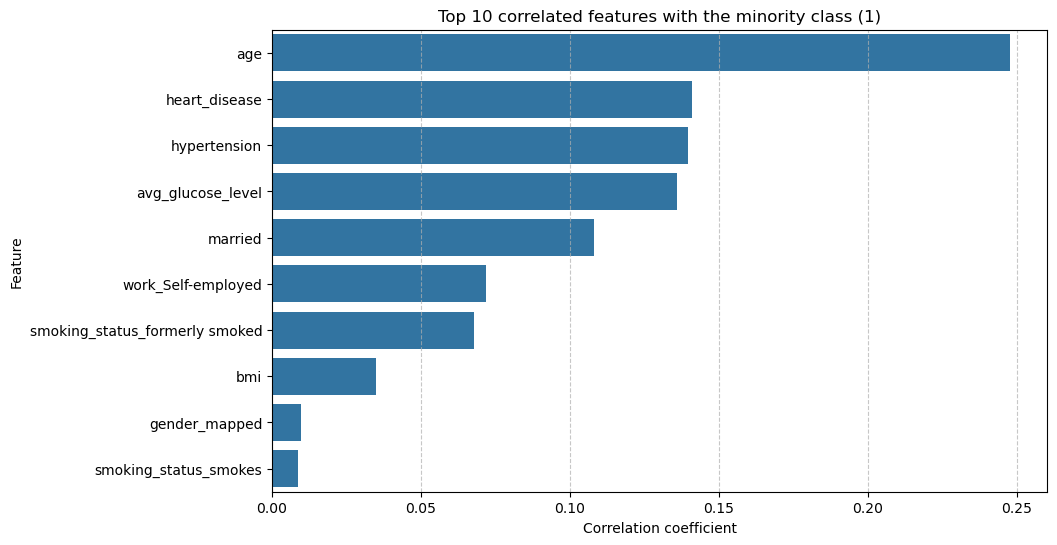

In [287]:
correlation_matrix = data.corr()

# Sort after the stroke
target_corr = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)

print(target_corr)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.head(10), y=target_corr.head(10).index)
plt.title("Top 10 correlated features with the minority class (1)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

* drop unecessary attributes

In [ ]:
# Drop the following columns
# "work_Never_worked", "work_children", "gender_Other", "ever_married"

data = data.drop(["id"], axis=1)

### Boxplot: Outliers

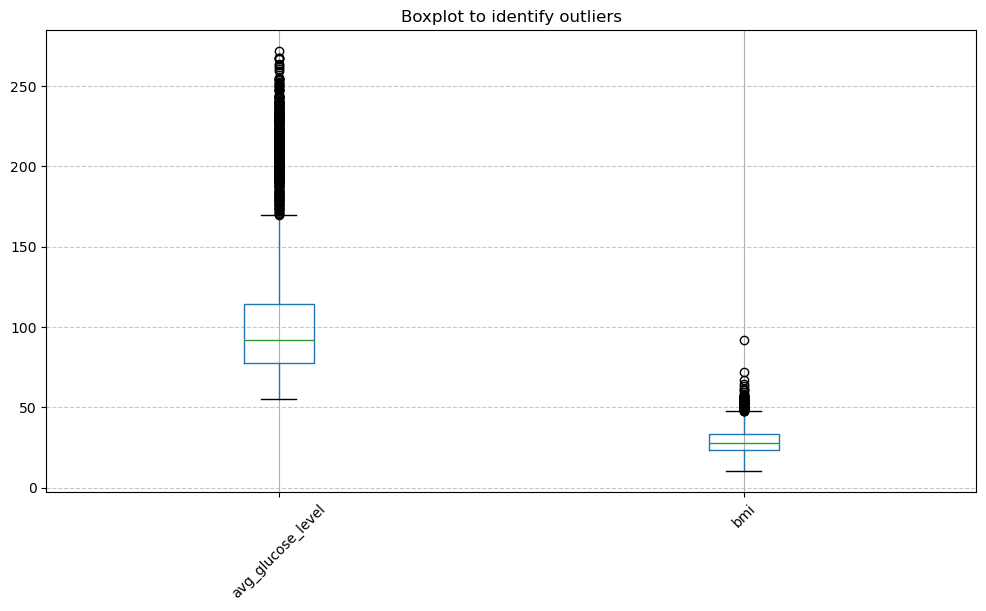

In [248]:
outlier_handeling = pd.concat([data["avg_glucose_level"], data["bmi"]], axis=1)

plt.figure(figsize=(12, 6))
outlier_handeling.boxplot()
plt.title("Boxplot to identify outliers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Distribution of the outcome

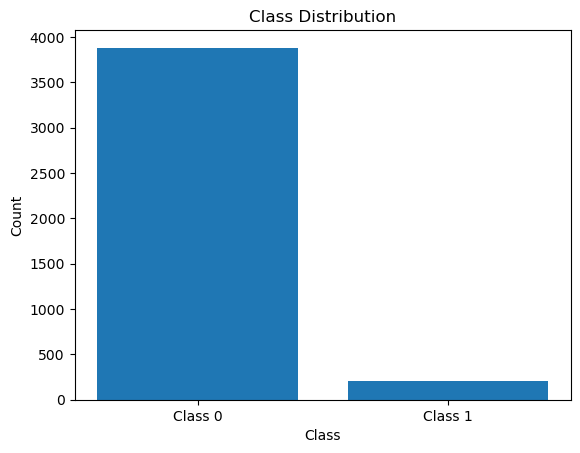

stroke
0    0.949609
1    0.050391
Name: proportion, dtype: float64


In [249]:
visualize_distribution_of_stroke(data["stroke"])

## Finetune the classifier
----

* Split data into test and train
* Handle the nan values
* Add new values with oversampling and undersample the values with a stroke of 1

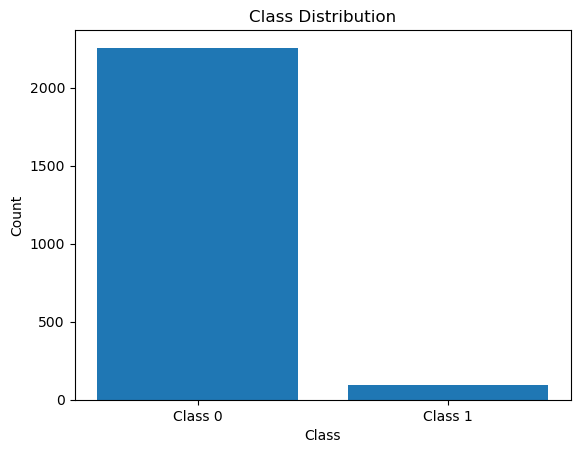

stroke
0    0.960801
1    0.039199
Name: proportion, dtype: float64


In [250]:
x = data.drop("stroke", axis=1)
y = data["stroke"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.4)
x_train, y_train = handle_nan(x_train, y_train)
#x_train, y_train = smote_enn_sampling (x_train, y_train)

# Changin the test data makes no sense, as the real test date will also have a 90 to 10 distribution
#x_test, y_test  = handle_nan(x_test, y_test )
#x_test, y_test = smote_enn_sampling (x_test, y_test)


visualize_distribution_of_stroke(y_train)

* Get max depth value

In [251]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf = clf.fit(x_train,y_train)

find_grid = get_grid(clf, x_train, y_train)
max_depth = find_grid.best_params_['max_depth']

print("Best max_depth:", max_depth)

Best max_depth: 9


* train classifier with class weight, max_depth & criterion 
* calculate the f1 score
* visualize what for a impact each attribute has

F1 Score: 8.82% 



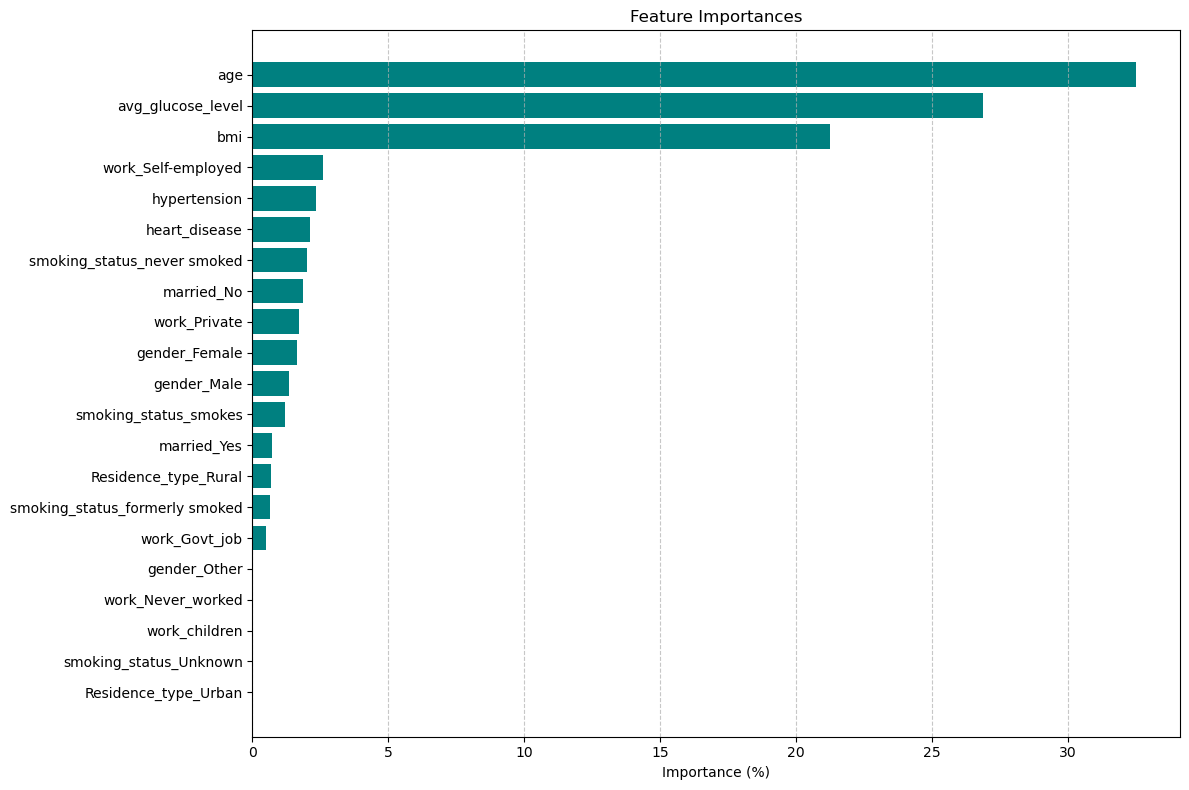

In [252]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth)
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = f1_score(y_test,y_pred,average='binary')
print(f"F1 Score: {round(acc * 100, 2)}% \n")

visualize_importances(clf)


---

#### Confuisionmatrix

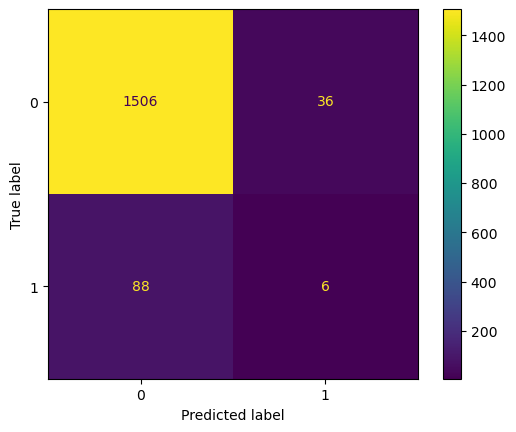

In [253]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# plot decussion tree
#tree.plot_tree(clf)

---